## Classification Models

- merge audio data with text data
- remove outlier cases
- split by holdout csv
- normalize/re-scale train data
- run t-tests with train data
- get top features and map to test set data

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# import sklearn modules 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
path = './data files/'

In [4]:
# get datasets

df_audio = pd.read_csv('Teacher_Mindfulness_Audio_Transcript_Features_20230214.csv').drop('Mood', axis=1)

text_url = 'https://raw.githubusercontent.com/eycooper/capstone/main/text_analytics_code/text_data.csv'
df_text = pd.read_csv(text_url)

In [5]:
# merge datasets
df = df_audio.merge(df_text,
                    left_on = 'ID', 
                    right_on = 'speaker_id')
df.drop(['speaker_id', 'Unnamed: 0'], axis = 1, inplace = True)

In [6]:
df.shape

(88, 131)

In [7]:
# remove outlier cases

drop_ids = [209, 303, 305, 312, 353, 354, 355]

for i in drop_ids:
    df.drop(df[df['ID'] == i].index, inplace=True)

In [8]:
df.shape

(81, 131)

In [9]:
# get train data for t-tests

train = df[df['holdout']==0].drop('holdout', axis=1)

### T-test on Train data

In [10]:
# Get list of all potential features in this data
feature_list = [col for col in train.columns if col not in ['ID', 'mindfulness']]

In [11]:
# Create empty df to hold t-test results
ttest_results = pd.DataFrame()

In [12]:
for feat in feature_list:
    # Separate treatment and control into separate dataframes
    # and select just this feature
    df_0 = train[train['mindfulness']==0]
    df_1 = train[train['mindfulness']==1]
    
    # Compute t test results for this feature
    temp_result = stats.ttest_ind(a = df_0[feat], 
                                  b = df_1[feat],
                                  equal_var = False)
    
    # Add t stat and p value to results df
    df_temp = pd.DataFrame({
                            'feature': feat,
                            'mean_0': df_0[feat].mean(),
                            'mean_1': df_1[feat].mean(),
                            't_statistic': temp_result[0],
                            'p_value': temp_result[1]
                            }, 
                            index = [0])
    
    ttest_results = pd.concat([ttest_results, df_temp], axis=0)

In [13]:
ttest_results.reset_index(inplace = True, drop = True)

In [14]:
# Sort by p-value to see which variables show the largest differences
ttest_results.sort_values('p_value', inplace = True)
ttest_results.head(10)

,feature,mean_0,mean_1,t_statistic,p_value
102,Zero_Crossing_Rate_Std,0.107811,0.095406,2.517768,0.014862
90,Centroid_Std,1279.611541,1158.368319,2.129085,0.037580
34,MFCC_4_Mean,7.070085,4.335195,1.975251,0.052709
13,Student_Word_Rate,2.096393,2.253935,-1.875983,0.065382
91,Bandwidth_Mean,1695.065860,1611.972062,1.869313,0.066158
74,MFCC_5_Kurtosis,0.195105,-0.050614,1.837706,0.072161
117,PC0,-0.013901,0.057527,-1.781490,0.079953
107,trust_norm,0.038106,0.029795,1.782992,0.081895
32,MFCC_2_Mean,9.365529,11.200496,-1.761333,0.083067
36,MFCC_6_Mean,-1.694941,-3.707593,1.742089,0.086380


After running a full t-test on the train data, there are only 2 statistically significant features: ZCR_Std & Centroid_Std that have a p-value less than 0.05.
In order to have a more well-rounded set of features for the model, we lowered the p-value threshold to < 0.10 - this gives us a set of 13 features for the baseline models.

In [15]:
# only the features that have a p-value < 0.10

top_feats = ttest_results[ttest_results['p_value'] < 0.10]

In [16]:
top_feats

,feature,mean_0,mean_1,t_statistic,p_value
102,Zero_Crossing_Rate_Std,0.107811,0.095406,2.517768,0.014862
90,Centroid_Std,1279.611541,1158.368319,2.129085,0.037580
34,MFCC_4_Mean,7.070085,4.335195,1.975251,0.052709
13,Student_Word_Rate,2.096393,2.253935,-1.875983,0.065382
91,Bandwidth_Mean,1695.065860,1611.972062,1.869313,0.066158
74,MFCC_5_Kurtosis,0.195105,-0.050614,1.837706,0.072161
117,PC0,-0.013901,0.057527,-1.781490,0.079953
107,trust_norm,0.038106,0.029795,1.782992,0.081895
32,MFCC_2_Mean,9.365529,11.200496,-1.761333,0.083067
36,MFCC_6_Mean,-1.694941,-3.707593,1.742089,0.086380


In [17]:
# save out top features into .csv file

top_feats.to_csv('Audio_Text_Top Features.csv')

In [18]:
# get top features into a list with ID and mindfulness

top_feats = [f for f in top_feats['feature']]
top_feats.append('ID')
top_feats.append('mindfulness')

In [19]:
# train/test sets with top features

train = train[top_feats]
test = df[df['holdout']==1].drop('holdout', axis=1)
test = test[top_feats]

In [20]:
train.shape, test.shape

((66, 15), (15, 15))

In [21]:
train.head()

,Zero_Crossing_Rate_Std,Centroid_Std,MFCC_4_Mean,Student_Word_Rate,Bandwidth_Mean,MFCC_5_Kurtosis,PC0,trust_norm,MFCC_2_Mean,MFCC_6_Mean,MFCC_12_Skew,Flatness_Mean,Teacher_Line_Count,ID,mindfulness
0,0.111820,1342.793978,8.994111,2.339405,1637.887678,-0.027963,-0.108105,0.036474,11.248416,3.552934,0.047610,0.019112,17,332,1
1,0.115759,1412.091525,7.795241,2.252683,1741.747397,-0.054601,0.324047,0.009901,9.074677,-0.395680,-0.148239,0.038517,23,348,1
3,0.117673,1391.276836,9.822735,1.901674,1710.442369,-0.104029,-0.076202,0.038005,9.608454,-1.317304,-0.206156,0.029412,26,320,1
6,0.101498,1315.081026,13.364434,1.762804,2019.452667,0.907372,-0.087677,0.043716,0.285001,3.789820,-0.297933,0.066644,29,314,1
7,0.087292,1057.137166,1.005453,1.839695,1501.139955,-0.631635,-0.036340,0.013834,11.030352,-4.901693,0.005384,0.004025,32,207,0


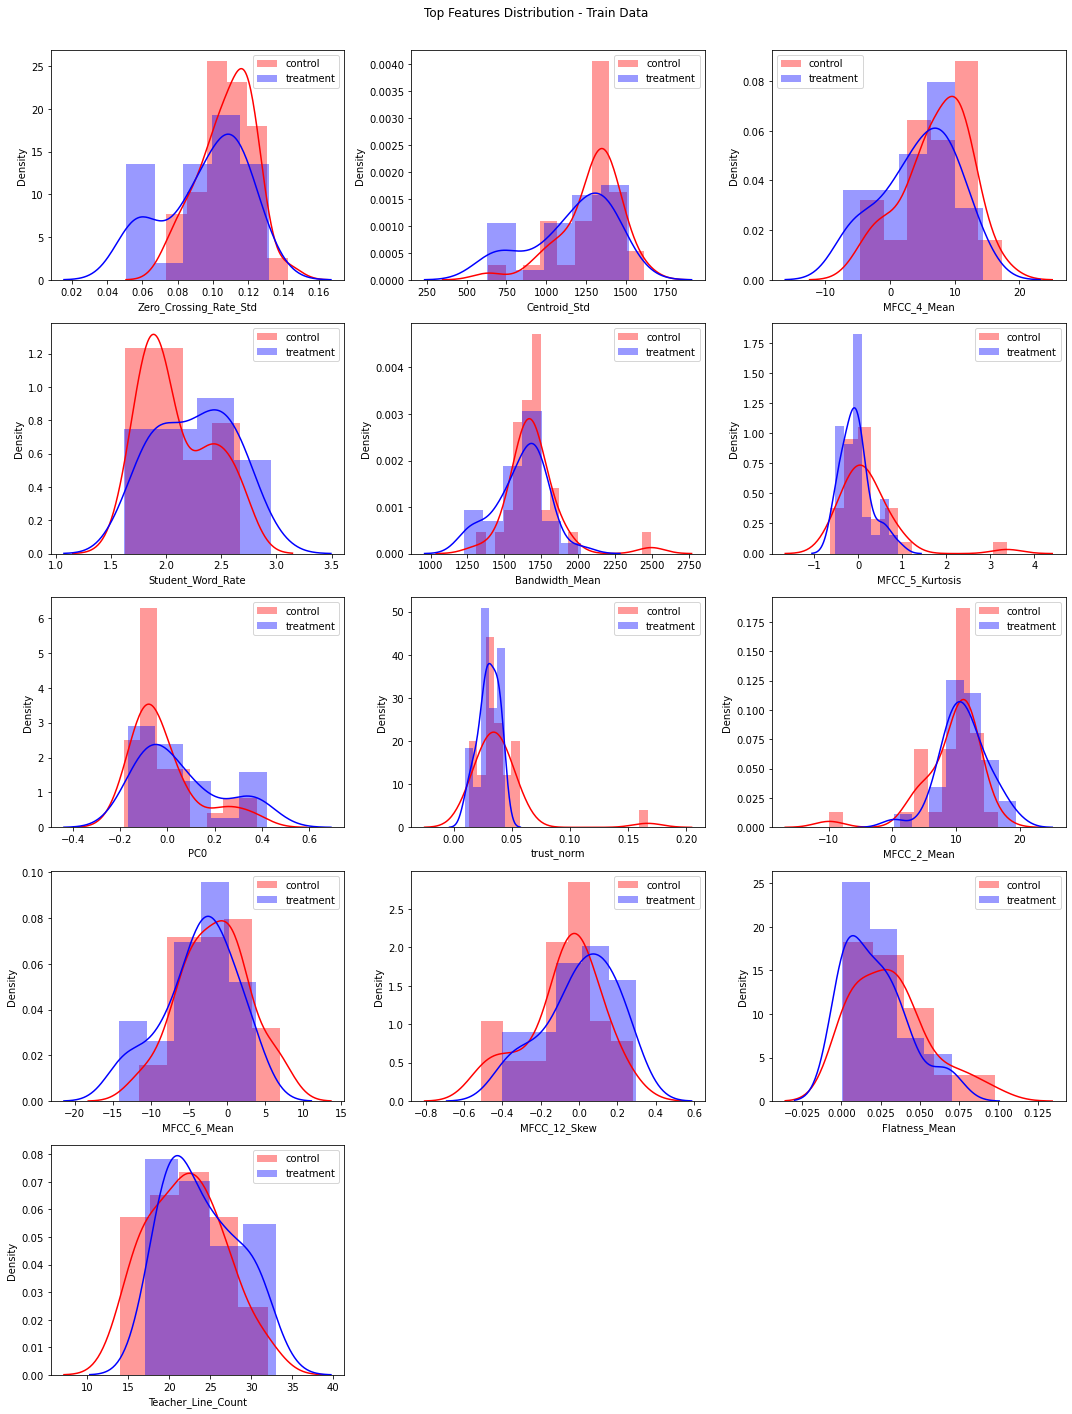

In [22]:
fig = plt.figure(figsize = (15, 20))
j = 0
for i in train.iloc[:,:-2]:
    plt.subplot(5, 3, j+1)
    j += 1
    sns.distplot(train[i][train['mindfulness']==0], color='red', label = 'control')
    sns.distplot(train[i][train['mindfulness']==1], color='blue', label = 'treatment')
    plt.legend(loc='best')
fig.suptitle('Top Features Distribution - Train Data')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Modeling

In [23]:
# feature vectors & target variable

X_train = train.drop(['mindfulness', 'ID'], axis=1)
y_train = train['mindfulness']

X_test = test.drop(['mindfulness', 'ID'], axis=1)
y_test = test['mindfulness']

In [24]:
# check shape

X_train.shape, X_test.shape

((66, 13), (15, 13))

#### Baseline Models

In [25]:
# compare models 
models = []

def classification_models(X_train, y_train):
    
    models.append(('Logistic Regression', LogisticRegression() ))
    models.append( ('SVC',  SVC()) )
    models.append( ('Naive Bayes',  GaussianNB()) )
    models.append( ('KNN', KNeighborsClassifier()) )
    models.append( ('Decision Tree', DecisionTreeClassifier()))
    
    model_names = []
    model_outcomes = []
    
    for name, model in models:
        results = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        
        model_names.append(name)
        model_outcomes.append(results.mean())
        
        # print(name, results.mean())
        
        model_df = pd.DataFrame(list(zip(model_names, model_outcomes)), columns =['Models', 'Train Accuracy'])
        
    return model_df
        
    # print(model_outcomes)       
    

In [26]:
train_results = pd.DataFrame()

In [27]:
train_results = classification_models(X_train, y_train)

In [28]:
# return results for each model + training accuracy 
round(train_results, 4)

,Models,Train Accuracy
0,Logistic Regression,0.6264
1,SVC,0.5791
2,Naive Bayes,0.6110
3,KNN,0.5615
4,Decision Tree,0.5615


In [29]:
# evaluation & prediction

def eval_predict_models(X_train, X_test, y_train, y_test):
    
    model_names = []
    model_outcomes = []

    for name, model in models:
        trainedmodel = model.fit(X_train, y_train)
    
        # prediction
        ypredict = trainedmodel.predict(X_test)
    
        acc = accuracy_score(y_test, ypredict)
        classreport = classification_report(y_test, ypredict)
        confMat = confusion_matrix(y_test, ypredict)
        
        model_names.append(name)
        model_outcomes.append(acc) 
        
        print('Model Type: {}'.format(name))
        print('The Classification Report:\n {}'.format(classreport))
        print('The Confusion Matrix:\n {}'.format(confMat))
        print('\n************')
    
        model_df = pd.DataFrame((model_names, model_outcomes)).T
        model_df.columns = ['Models', 'Test Accuracy']
    
    return model_df

In [30]:
test_results = pd.DataFrame()

In [31]:
test_results = eval_predict_models(X_train, X_test, y_train, y_test)

Model Type: Logistic Regression
The Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.50      0.43      0.46         7

    accuracy                           0.53        15
   macro avg       0.53      0.53      0.52        15
weighted avg       0.53      0.53      0.53        15

The Confusion Matrix:
 [[5 3]
 [4 3]]

************
Model Type: SVC
The Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           1       0.33      0.14      0.20         7

    accuracy                           0.47        15
   macro avg       0.42      0.45      0.40        15
weighted avg       0.42      0.47      0.41        15

The Confusion Matrix:
 [[6 2]
 [6 1]]

************
Model Type: Naive Bayes
The Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.

In [32]:
model_results = train_results.merge(test_results, on='Models')
round(model_results, 4)

,Models,Train Accuracy,Test Accuracy
0,Logistic Regression,0.6264,0.533333
1,SVC,0.5791,0.466667
2,Naive Bayes,0.6110,0.4
3,KNN,0.5615,0.4
4,Decision Tree,0.5615,0.466667


Logistic Regression had the best performing model on the test data, however with the accuracy score still at 0.53, it indicates that the model does no better than just a random guess. 

### Hyperparameter Tuning 

#### Logistic Regression

In [33]:
logreg = LogisticRegression().fit(X_train, y_train)

In [36]:
logreg_params = {'penalty': ['l1', 'l2', 'none'],
                 'C': [0.001, 0.01, 0.1, 1, 10, 100],
                 'solver': ['liblinear', 'newton-cg']}

logreg_clf = GridSearchCV(estimator=logreg, 
                     param_grid=logreg_params, 
                     cv=5,
                     scoring='accuracy')

logreg_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'none'],
                         'solver': ['liblinear', 'newton-cg']},
             scoring='accuracy')

In [37]:
logreg_clf.best_params_

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [38]:
logreg_clf.best_score_

0.6692307692307693

In [39]:
logreg_best = LogisticRegression(penalty='l1', solver='liblinear', C=100).fit(X_train, y_train)

In [40]:
logreg_pred = logreg_best.predict(X_test)
logreg_acc = accuracy_score(y_test, logreg_pred)
logreg_acc

0.4666666666666667

In [41]:
logreg_pred_train = logreg_best.predict(X_train)
logreg_train_acc = accuracy_score(y_train, logreg_pred_train)
logreg_train_acc

0.7272727272727273

In [42]:
logreg_cv = cross_val_score(logreg_best, X_train, y_train, cv=5, scoring='accuracy').mean()
logreg_cv

0.6692307692307693

In [45]:
logreg_results = ['Logistic Regression', round(logreg_cv, 4), round(logreg_acc, 4)]
logreg_results

['Logistic Regression', 0.6692, 0.4667]

#### SVC

In [46]:
svc = SVC().fit(X_train, y_train)

In [47]:
svc_params = {'kernel': ['linear', 'rbf'],
                     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

svc_clf = GridSearchCV(estimator=svc, 
                     param_grid=svc_params, 
                     cv=5,
                     scoring='accuracy')

svc_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [48]:
svc_clf.best_params_

{'C': 0.01, 'kernel': 'linear'}

In [49]:
svc_clf.best_score_

0.610989010989011

In [50]:
svc_best = SVC(kernel='linear', C=0.01).fit(X_train, y_train)

In [51]:
svc_pred = svc_best.predict(X_test)
svc_acc = accuracy_score(y_test, svc_pred)
svc_acc

0.5333333333333333

In [52]:
svc_pred_train = svc_best.predict(X_train)
svc_pred_acc = accuracy_score(y_train, svc_pred_train)
svc_pred_acc

0.6212121212121212

In [53]:
svc_cv = cross_val_score(svc_best, X_train, y_train, cv=5, scoring='accuracy').mean()
svc_cv

0.610989010989011

In [54]:
svc_results = ['SVC', round(svc_cv, 4), round(svc_acc, 4)]
svc_results

['SVC', 0.611, 0.5333]

#### Gaussian Naive Bayes

In [55]:
gnb = GaussianNB().fit(X_train, y_train)

In [56]:
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=0)

In [57]:
gnb_params = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb_clf = GridSearchCV(estimator=gnb, 
                     param_grid=gnb_params, 
                     cv=cv_method,
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_train)

gnb_clf.fit(Data_transformed, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=0),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.3...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [58]:
gnb_clf.best_params_

{'var_smoothing': 1.0}

In [59]:
gnb_clf.best_score_

0.6146520146520146

In [60]:
gnb_best = GaussianNB(var_smoothing=1.0).fit(Data_transformed, y_train)

In [61]:
gnb_pred = gnb_best.predict(PowerTransformer().fit_transform(X_test))
gnb_acc = accuracy_score(y_test, gnb_pred)
gnb_acc

0.4666666666666667

In [62]:
gnb_pred_train = gnb_best.predict(Data_transformed)
gnb_pred_acc = accuracy_score(y_train, gnb_pred_train)
gnb_pred_acc

0.6363636363636364

In [63]:
gnb_cv = cross_val_score(gnb_best, Data_transformed, y_train, cv=5, scoring='accuracy').mean()
gnb_cv

0.6098901098901098

In [64]:
gnb_results = ['Gaussian Naive Bayes', round(gnb_cv, 4), round(gnb_acc, 4)]
gnb_results

['Gaussian Naive Bayes', 0.6099, 0.4667]

#### KNN

In [65]:
knn = KNeighborsClassifier().fit(X_train, y_train)

In [66]:
knn_params = {'leaf_size': list(range(1,50)),
              'n_neighbors': list(range(1,20)),
              'p': [1,2],
              'weights': ['uniform', 'distance']}

knn_clf = GridSearchCV(estimator=knn, 
                       param_grid=knn_params, 
                       cv=5,
                       scoring='accuracy')

knn_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [67]:
knn_clf.best_params_

{'leaf_size': 1, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}

In [68]:
knn_clf.best_score_

0.5934065934065933

In [69]:
knn_best = KNeighborsClassifier(leaf_size=1, n_neighbors=6, p=2, weights='distance').fit(X_train, y_train)

In [70]:
knn_pred = knn_best.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
knn_acc

0.4666666666666667

In [71]:
knn_pred_train = knn_best.predict(X_train)
knn_pred_acc = accuracy_score(y_train, knn_pred_train)
knn_pred_acc

1.0

In [72]:
knn_cv = cross_val_score(knn_best, X_train, y_train, cv=5, scoring='accuracy').mean()
knn_cv

0.5472527472527473

In [73]:
knn_results = ['KNN', round(knn_cv, 4), round(knn_acc, 4)]
knn_results

['KNN', 0.5473, 0.4667]

#### Decision Tree

In [74]:
dtree = DecisionTreeClassifier().fit(X_train, y_train)

In [77]:
# look for optimal ranges of max_depth & max_leaf_nodes to test

for max_d in range(1,11):
  m = DecisionTreeClassifier(max_depth=max_d, random_state=0)
  m.fit(X_train, y_train)
  print('The Training Accuracy for max_depth {} is:'.format(max_d), m.score(X_train, y_train))
  print('The Validation Accuracy for max_depth {} is:'.format(max_d), m.score(X_test, y_test))
  print('')

for max_l in range(5,21):
  m = DecisionTreeClassifier(max_leaf_nodes=max_l, random_state=0)
  m.fit(X_train, y_train)
  print('The Training Accuracy for max_leaf_nodes {} is:'.format(max_l), m.score(X_train, y_train))
  print('The Validation Accuracy for max_leaf_nodes {} is:'.format(max_l), m.score(X_test, y_test))
  print('')

The Training Accuracy for max_depth 1 is: 0.6212121212121212
The Validation Accuracy for max_depth 1 is: 0.4

The Training Accuracy for max_depth 2 is: 0.696969696969697
The Validation Accuracy for max_depth 2 is: 0.4

The Training Accuracy for max_depth 3 is: 0.7727272727272727
The Validation Accuracy for max_depth 3 is: 0.4

The Training Accuracy for max_depth 4 is: 0.8484848484848485
The Validation Accuracy for max_depth 4 is: 0.4666666666666667

The Training Accuracy for max_depth 5 is: 0.9545454545454546
The Validation Accuracy for max_depth 5 is: 0.3333333333333333

The Training Accuracy for max_depth 6 is: 0.9696969696969697
The Validation Accuracy for max_depth 6 is: 0.4666666666666667

The Training Accuracy for max_depth 7 is: 0.9848484848484849
The Validation Accuracy for max_depth 7 is: 0.4

The Training Accuracy for max_depth 8 is: 1.0
The Validation Accuracy for max_depth 8 is: 0.4

The Training Accuracy for max_depth 9 is: 1.0
The Validation Accuracy for max_depth 9 is: 0

In [78]:
dtree_params = {'max_depth': list(range(1,8)),
              'max_leaf_nodes': list(range(5,11))}

dtree_clf = GridSearchCV(estimator=dtree, 
                       param_grid=dtree_params, 
                       cv=5,
                       scoring='accuracy')

dtree_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

In [79]:
dtree_clf.best_params_

{'max_depth': 4, 'max_leaf_nodes': 5}

In [80]:
dtree_clf.best_score_

0.5472527472527473

In [81]:
dtree_best = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=5).fit(X_train, y_train)

In [82]:
dtree_pred = dtree_best.predict(X_test)
dtree_acc = accuracy_score(y_test, dtree_pred)
dtree_acc

0.3333333333333333

In [83]:
dtree_pred_train = dtree_best.predict(X_train)
dtree_pred_acc = accuracy_score(y_train, dtree_pred_train)
dtree_pred_acc

0.803030303030303

In [84]:
dtree_cv = cross_val_score(dtree_best, X_train, y_train, cv=5, scoring='accuracy').mean()
dtree_cv

0.5472527472527473

In [85]:
dtree_results = ['Decision Tree', round(dtree_cv, 4), round(dtree_acc, 4)]
dtree_results

['Decision Tree', 0.5473, 0.3333]

#### Final Model Comparison

In [86]:
final_model_results = pd.DataFrame([logreg_results, svc_results, gnb_results, knn_results, dtree_results])
final_model_results.columns = ['Model', 'Train Accuracy', 'Test Accuracy']
final_model_results

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.6692,0.4667
1,SVC,0.6110,0.5333
2,Gaussian Naive Bayes,0.6099,0.4667
3,KNN,0.5473,0.4667
4,Decision Tree,0.5473,0.3333


In [87]:
# compare to baseline model results

round(model_results, 4)

,Models,Train Accuracy,Test Accuracy
0,Logistic Regression,0.6264,0.533333
1,SVC,0.5791,0.466667
2,Naive Bayes,0.6110,0.4
3,KNN,0.5615,0.4
4,Decision Tree,0.5615,0.466667


SVC, Naive Bayes, and KNN improved after hyperparameter tuning. Logistic Regression prior to hyperparameter tuning, and SVC post-hyperparameter tuning had the best performing models with a test accuracy of 0.533 for both. 

#### Classification Report & Confusion Matrix

In [88]:
# SVC

svc_classreport = classification_report(y_test, svc_pred)
svc_confMat = confusion_matrix(y_test, svc_pred)

In [90]:
print('SVC')
print(svc_classreport)
print(svc_confMat)

SVC
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.50      0.43      0.46         7

    accuracy                           0.53        15
   macro avg       0.53      0.53      0.52        15
weighted avg       0.53      0.53      0.53        15

[[5 3]
 [4 3]]


In [92]:
# fit original LogReg model to get classification and confusion matrix numbers

logreg = LogisticRegression().fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(y_test, logreg_pred)


logreg_classreport = classification_report(y_test, logreg_pred)
logreg_confMat = confusion_matrix(y_test, logreg_pred)

In [93]:
print('Logistic Regression')
print(logreg_classreport)
print(logreg_confMat)

Logistic Regression
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.50      0.43      0.46         7

    accuracy                           0.53        15
   macro avg       0.53      0.53      0.52        15
weighted avg       0.53      0.53      0.53        15

[[5 3]
 [4 3]]
